In [1]:
## Loading Libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt 
from random import uniform
import random
from copy import deepcopy
import warnings
import pickle
from time import gmtime, strftime
import pytz

# import power_index_calculator as px
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from generateRandSeed import generateRandSeed
from plot_simulation_output import plot_simulation_output

In [3]:
G = nx.erdos_renyi_graph(10,3/10)
edge_weight = dict(zip(G.edges(),[uniform(0.01,0.1) for x in range(len(G.edges()))]))
nx.set_edge_attributes(G,edge_weight,'weight')
node_weight = dict(zip(G.nodes(),[random.randrange(10,20) for x in range(len(G.nodes()))]))
nx.set_node_attributes(G,node_weight,'test')

TimePolicy_generator(G,Maximum_Time=15,
    method = {'name':'random','group_num':4})


Nodes_dict =  dict(G.nodes(data=True))
Nodes_list = list(Nodes_dict)
gn = 4

node_group = {k:v for (k,v) in zip(Nodes_list,[random.randrange(1,gn+1) for i in range(len(Nodes_list))])}
# node_group
# random.sample(Nodes_list, 3)
random.shuffle(Nodes_list)
List = chunkIt(Nodes_list, gn)        
group_node = {k:v for (k,v) in zip(list(range(1,gn+1)),List)}
# group_node
time_node = {k:group_node[i%gn+1] for (k,i) in zip(list(range(1,20+1)),list(range(1,20+1)))}
# time_node

NameError: name 'TimePolicy_generator' is not defined

In [3]:
random.randrange(1,2+1)

2

In [4]:
def chunkIt(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0

    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg

    return out

############################
def TimePolicy_generator(Graph,Maximum_Time=10000,
    method = {'name':'random','group_num':2}):
    
    # Size of Graph
    lng = Graph.number_of_nodes()
    
    Nodes_dict =  dict(Graph.nodes(data=True))
    Nodes_list = list(Nodes_dict)
    
    if method['name'] is 'random':
        # Assigning groups
        random.shuffle(Nodes_list)
        List = chunkIt(Nodes_list, method['group_num'])
        group_node = {k:v for (k,v) in zip(list(range(1,method['group_num']+1)),List)}
        
        time_node = {k:set(group_node[i%method['group_num']+1]) for (k,i) in zip(list(range(1,Maximum_Time+1)),list(range(1,Maximum_Time+1)))}
        return(time_node)
    
    elif method['name'] is 'degree':
        pass
        # # Setting Node Attributes
        # node_weight = dict(zip(Graph.nodes(),[random.randrange(10,20) for x in range(lng)]))
        # nx.set_node_attributes(Graph,node_weight,'test')
    else:
        raise ValueError('Wrong input for method["name"]!')
    

In [46]:
def Simulate_SIR_Time (Graph,Maximum_Time=100,Seasons=[50,100,150,200],P_seasons = [1,1,1,1],
                       Seeds = [0,7], n_dr=1, q_die=0.2, n_s=1, q_s=0.1, how='Transmission',
                       time_policy={'mode':'NoPlolicy','p':'','group_num':2,'method':'random'},pnt=False):
    
    """ A function to run a cascade simulation on a graph.

  The cascade is based on the SIR model in each time step.
  ....

  Parameters
  ----------
  Graph: networkx.Graph object
    The graph to run the simulation on! Each edge must have a weight
    that shows the probability of transmission.

  Maximum_Time: int
    Maximum time that the simulation is run if it does not cnoverge!

  Seasons: list of integers
    Each element shows the moment of season change.

  P_seasons: list of floats
    The Pr[tansmission] is multiplied by the p_season for each season.

  Seeds: list of integers
    Initial Seeds.
  
  n_dr: int
    Number of time steps that after infection a node dies or recovers.
  
  q_die: float
    Probability of dying at n_dr day after infection

  n_s: int
    Number of time steps that after infection a node shows symptoms.
    After showing symptoms, edge weights are multiplied by q_s.

  q_s: float
    See n_s.

  how: str
    It can be 'Transmission' or 'New_Infection'. 
    In the 'Transmission' mode, R0 is calculated as the number of virus tranmission
     (ignoring the fact that the receiver node is already infected or not).
    In the 'New_Infection' mode, R0 is calculated the number of new infected nodes,
     caused by a node in its sickness period.
  
  Attention
  ---------
  If in this simulation if we put n_dr=1, we have the simple SIR model.

  """
    # Size of Graph
    lng = Graph.number_of_nodes()

     # Checking inputs
    if n_s>n_dr:
        warnings.warn("n_s(time to show symptoms) should be less than n_dr(time to die or recovers)")

    if len(Seeds)>lng:
        raise ValueError('"numSeed" cannot be larger than Graph size')
      
    if len([x for x in Seeds if x>=lng])>lng:
        raise ValueError('Initial Seeds must be in Graph!') 
        
    if not isinstance(Graph,nx.Graph):
        raise ValueError('"Graph" must be a networkx.Graph object!')
        
    if q_die>1 or q_die<0 or q_s<0 or q_s>1 or len([x for x in P_seasons if x<0]):
        raise ValueError('Probabilities (q_s,q_die, P_seasons) must be between 0 and 1!')
        
    if how not in ['Transmission','New_Infection']:
        raise ValueError('"how" must be "Transmission" or "New_Infection"')

    # Sorting elements of Seasons
    Seasons.sort()      

    ## Creating Neighbor List
    Neighbors_List = []
    Nodes = list(Graph.nodes())
    Nodes.sort(reverse=False)
    # Finding Neighbors of each node
    for node in list(Nodes):
        Neighbors_List.append(dict(Graph.adj[node]))


    ## Initializing the Status Lists
    Normal = list(range(lng))
    Infected = list()
    Died = list()
    Recovered = list()
  
    # Adding initial seeds to infected list
    Infected = [x for x in Seeds]

    # Timer for infecteds
    Infected_timer = [0]*len(Seeds)

    # Removing infecteds from Normal list
    for node in Infected:
        Normal.remove(node)
      
    # Declaring output R0 lists
    R0_Node_list = [0]*lng
    R0_time_list = []

    # Declaring level lists
    Normal_size =[]
    Infected_size =[]
    Recovered_size =[]
    Died_size =[]
  
    # Setting first elements
    Normal_size.append(len(Normal))
    Infected_size.append(len(Seeds))
    Recovered_size.append(0)
    Died_size.append(0)
    
    
    # Activity finding
    if time_policy['mode'] is 'deterministic':
        Time_Active_dict = TimePolicy_generator(Graph,Maximum_Time=Maximum_Time,
        method = {'name':time_policy['method'],'group_num':time_policy['group_num']})
        if pnt:
            print('time_policy is {}\n\n'.format([[x,Time_Active_dict[x]] for x in range(1,time_policy['group_num']+1)]))


    # Going through time 
    for t in range(1,Maximum_Time+1):
        if pnt:
            print('************** Time {}**************'.format(t))
      
        # If there is no Infected we are on steady state. So quit!
        if len(Infected)==0:
            break
        # R_t
        R0_t = 0
    
        # Finding Season
        if  t<Seasons[0]:
            p_s = P_seasons[0]
        elif t>=Seasons[0] and t<Seasons[1]:
            p_s = P_seasons[1]
        elif t>=Seasons[1] and t<Seasons[2]:
            p_s = P_seasons[2]
        elif t>=Seasons[2] and t<Seasons[3]:
            p_s = P_seasons[3]
        else:
            p_s = 1
            

        # Finding nodes that must die or recover (based on the timer)
        DieRecover = [x for x,y in zip(Infected,Infected_timer) if y == n_dr]
        
      
        # For updating netwok, Finding nodes that their neighbor just died or . . .
        # . . . recovered so their neighbor list must be updated.                    
        nhbr_rd = set()
        # For each node in DieRecover list
        for node in DieRecover:
            # The neighbors of the dead or recoverd node need to be modified
            nhbr_rd = nhbr_rd.union(Graph.adj[node])    

            # We delete that node from infecteds and timer
            index = Infected.index(node)
            del Infected_timer[index]
            del Infected[index]

            # We remove the edges for that node (Recovereds can not get sick again)
            Graph.remove_edges_from(list(Graph.edges(node)))
          
            # We see they die or recover with respect to q_die
            if uniform(0,1) < q_die:
                # It dies
                Died.append(node)

            else:
                # It recovers
                Recovered.append(node)
      
        if pnt:
            print('DieRecover is    : ',DieRecover)
            print('Died is          : ',Died)
            print('Recovered is     : ',Recovered)
            print('Normal is        : ',Normal)
            print('Infected is      : ',Infected)
            print('Infected_timer is: ',Infected_timer)
            
        
        # Updating Neighbor List for nodes that their neighbrs are died or recoverd
        for neighbor in nhbr_rd:
            Neighbors_List[neighbor] = dict(Graph.adj[neighbor]) 
            
        
        # Determining Active nodes
        if time_policy['mode'] is 'deterministic':
            ActiveNodes = Time_Active_dict[t].intersection(set(Normal+Infected))
        elif time_policy['mode'] is 'stochastic':
            p_active = time_policy['p']
            ActiveNodes = set([x for x in Normal+Infected if uniform(0,1)<p_active])
        else:
            ActiveNodes = set(Normal+Infected)
            warnings.warn('"time_policy"["mode"] must be "deterministic" or "stochastic"!')
        if pnt:
            print('ActiveNodes is         : ',ActiveNodes)
            print('Infected*ActiveNodes is: ',set(Infected).intersection(ActiveNodes))
            
            
        # Cascade...
        # New infected nodes in each time step
        New_Infected = []
        # For each Infected node we try to find the transmissions
        for node in set(Infected).intersection(ActiveNodes):
    
            # Number of Transmission by this node in this time step
            R0 = 0
          
            # Checking if the node has symptoms
            if Infected_timer[Infected.index(node)] < n_s:
                Q = 1
            else:
                Q = q_s
                   
            ## Finding the Neighbors of the node based on the how (transmission or new infection)
            if how is 'Transmission':
                Neighbors = {k:v for k,v in Neighbors_List[node].items() if k in ActiveNodes}               

            else:
                Neighbors = {k:v for k,v in Neighbors_List[node].items() if k in Normal and k in ActiveNodes}
                
            if pnt:
                print('\n*Node {} is selected and its all neigbohrs are {} and its active neighbors are {}'.format(
                    node,list(Neighbors_List[node]),list(Neighbors)))
          
            # For each neighbor
            for advicee in Neighbors:
                # Gets informed with respect to edge probability, symptoms, season
                if  uniform(0,1)<Neighbors[advicee]['weight']*Q*p_s:
                    # Increasing the R-0 for node and time
                    R0+=1
                    R0_t+=1  
                    # If its a new node (which is not already informed) we update the list of informeds
                    if advicee in Normal:
                        Normal.remove(advicee)
                        New_Infected.append(advicee)
                        
                    if pnt:
                        print('**Node {} got informed!'.format(advicee))
                        print('**Normal is        : ',Normal)
                        print('**New_Infected is  : ',New_Infected)
                        
          

            # Updating number of new infected for this node
            R0_Node_list[node] = R0_Node_list[node]+R0
          

        ## Increasing Timer of nodes ##
        Infected_timer = [x+1 for x in Infected_timer]

        ## Updaint list of R_t
        try: 
            R0_time_list.append(R0_t/len(Infected))

        except:
            R0_time_list.append(np.nan)

        # Updating Infected list and the timer
        Infected = Infected + New_Infected
        Infected_timer = Infected_timer + len(New_Infected)*[0]
      
        # Updating level sizes in each step
        Normal_size.append(len(Normal))
        Infected_size.append(len(Infected))
        Recovered_size.append(len(Recovered))
        Died_size.append(len(Died))
        
        if t==Maximum_Time:
            raise ValueError('Increase Maximum_Time! Time ended before the end of the cascade!')
            
            
    # Keeping nodes which got infected 
    R0_Infected_Nodes = {k:R0_Node_list[k] for k in range(len(R0_Node_list)) if k not in Normal}
  
    # The level output
    level = pd.DataFrame(data={'time':list(range(len(Normal_size))),
                             'Normal':Normal_size,
                             'Infected':Infected_size,
                             'Recovered':Recovered_size,
                             'Died':Died_size})
    
    
    # Finding The Interval in Peak
    temp = list(level.Infected)
    Peak = max(temp)
    t_peak = temp.index(Peak)
    val_list = [abs(x-0.5*Peak) for x in temp]

    try:
        t1 = val_list.index(min(val_list[0:t_peak]))
        t2 = val_list[t_peak:].index(min(val_list[t_peak:]))+t_peak
        Peak_int = t2-t1
    except:
        Peak_int = np.nan
    
    
    OUT={'Level':level,'R0_Nodes':R0_Infected_Nodes,'R0':np.mean(list(R0_Infected_Nodes.values())),
         'Cascade':(len(Died)+len(Recovered)+len(Infected))/lng,'R0_time_list':[0]+R0_time_list,
         'Peak':Peak/lng,'Peak_int':Peak_int}
    return(OUT)


In [47]:
a = [1,1,1,2,1,1,1]
Peak = max(a)
t_peak = a.index(Peak)
t_peak




3

# **Run Your Simulation**

In the below example, we create an Erdos-Renyi graph and we run the simulation and plot the outputs.

The average R0 is 1.505, and the fraction of Infected people are 0.713, The method was "Transmission", and Peak_int is 17


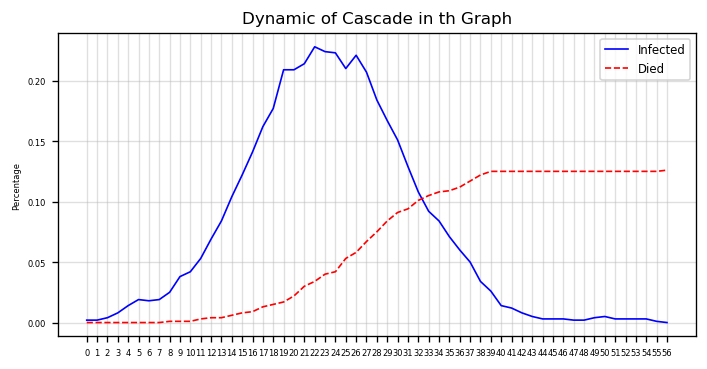

Wall time: 2.5 s


()

In [50]:
%%time
# Example
n = 1000
d = 20
G = nx.erdos_renyi_graph(n,d/n)
edge_weight = dict(zip(G.edges(),[uniform(0.01,0.5) for x in range(len(G.edges()))]))
nx.set_edge_attributes(G,edge_weight,'weight')

method = 'Transmission'
out = Simulate_SIR_Time (deepcopy(G),Maximum_Time=100,Seasons=[20,40,60,80],P_seasons = [1,1,1,1],
                   Seeds = generateRandSeed(2,G), n_dr=5, q_die=0.2, n_s=4, q_s=0.3, how=method,
                        time_policy={'mode':'stochastic','p':0.3,'group_num':2,'method':'random'},pnt=False)

print('The average R0 is {:0.3f}, and the fraction of Infected people are {:0.3f}, The method was "{}", and Peak_int is {}'.format(out['R0'],out['Cascade'],method,out['Peak_int']))
plot_simulation_output(Graphsize=G.number_of_nodes(),data = out,module=['Infected','Died'])

In [8]:
out['Peak']

0.291